In [477]:
import sys
import argparse
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import matplotlib.image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from hw5_utils import *




# The "encoder" model q(z|x)
class Encoder(nn.Module):
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Encoder, self).__init__()
        # Input:
        #   latent_dimension: the latent dimension of the encoder
        #   hidden_units: the number of hidden units
        
        self.fc1 = nn.Linear(data_dimension, hidden_units)
        self.fc2_mu = nn.Linear(hidden_units, latent_dimension)
        self.fc2_sigma = nn.Linear(hidden_units, latent_dimension)

    def forward(self, x):
        # Input: x input image [batch_size x data_dimension]
        # Output: parameters of a diagonal gaussian 
        #   mean : [batch_size x latent_dimension]
        #   variance : [batch_size x latent_dimension]

        hidden = torch.tanh(self.fc1(x))
        mu = self.fc2_mu(hidden)
        log_sigma_square = self.fc2_sigma(hidden)
        sigma_square = torch.exp(log_sigma_square)  
        return mu, sigma_square


# "decoder" Model p(x|z)
class Decoder(nn.Module):
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Decoder, self).__init__()
        # Input:
        #   latent_dimension: the latent dimension of the encoder
        #   hidden_units: the number of hidden units

        # TODO: deine the parameters of the decoder
        # fc1: a fully connected layer with 500 hidden units. 
        # fc2: a fully connected layer with 500 hidden units. 
        self.fc1 = nn.Linear(latent_dimension,hidden_units)
        self.fc2 = nn.Linear(hidden_units,data_dimension)
    def forward(self, z):
        # input
        #   z: latent codes sampled from the encoder [batch_size x latent_dimension]
        # output 
        #   p: a tensor of the same size as the image indicating the probability of every pixel being 1 [batch_size x data_dimension]

        # TODO: implement the decoder here. The decoder is a multi-layer perceptron with two hidden layers. 
        # The first layer is followed by a tanh non-linearity and the second layer by a sigmoid.
        p = F.tanh(self.fc1(z))
        p = F.sigmoid(self.fc2(p))
        return p


# VAE model
class VAE(nn.Module):
    #def __init__(self, args):
    def __init__(self):
        super(VAE, self).__init__()
        #self.latent_dimension = args.latent_dimension
        #self.hidden_units =  args.hidden_units
        #self.data_dimension = args.data_dimension
        #self.resume_training = args.resume_training
        #self.batch_size = args.batch_size
        #self.num_epoches = args.num_epoches
        #self.e_path = args.e_path
        #self.d_path = args.d_path
        
        self.latent_dimension = 2
        self.hidden_units =  500
        self.data_dimension = 784
        self.resume_training = False
        self.batch_size = 100
        self.num_epoches = 200
        self.e_path = "e_params.pkl"
        self.d_path = "d_params.pkl"

        # load and pre-process the data
        N_data, self.train_images, self.train_labels, test_images, test_labels = load_mnist()

        # Instantiate the encoder and decoder models 
        self.encoder = Encoder(self.latent_dimension, self.hidden_units, self.data_dimension)
        self.decoder = Decoder(self.latent_dimension, self.hidden_units, self.data_dimension)

        # Load the trained model parameters
        if self.resume_training:
            self.encoder.load_state_dict(torch.load(self.e_path))
            self.decoder.load_state_dict(torch.load(self.d_path))

    # Sample from Diagonal Gaussian z~N(μ,σ^2 I) 
    @staticmethod
    def sample_diagonal_gaussian(mu, sigma_square):
        # Inputs:
        #   mu: mean of the gaussian [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
        # Output:
        #   sample: from a diagonal gaussian with mean mu and variance sigma_square [batch_size x latent_dimension]

        # TODO: Implement the reparameterization trick and return the sample z [batch_size x latent_dimension]
        #std = torch.exp(0.5*sigma_square)
        #eps = torch.randn_like(std)
        #smaple = mu + eps * std
        sample = torch.distributions.Normal(mu,torch.sqrt(sigma_square)).sample()
        #sample = m.sample()
        return sample

    # Sampler from Bernoulli
    @staticmethod
    def sample_Bernoulli(p):
        # Input: 
        #   p: the probability of pixels labeled 1 [batch_size x data_dimension]
        # Output:
        #   x: pixels'labels [batch_size x data_dimension]

        # TODO: Implement a sampler from a Bernoulli distribution
        x = torch.bernoulli(p)
        return x


    # Compute Log-pdf of z under Diagonal Gaussian N(z|μ,σ^2 I)
    @staticmethod
    def logpdf_diagonal_gaussian(z, mu, sigma_square):
        # Input:
        #   z: sample [batch_size x latent_dimension]
        #   mu: mean of the gaussian distribution [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian distribution [batch_size x latent_dimension]
        # Output:
        #    logprob: log-probability of a diagomnal gaussian [batch_size]
        
        # TODO: implement the logpdf of a gaussian with mean mu and variance sigma_square*I

        logprob = (torch.log(1./torch.sqrt(2*np.pi*sigma_square))-0.5*(z-mu)**2/sigma_square).sum(axis=1)
        return logprob

    # Compute log-pdf of x under Bernoulli 
    @staticmethod
    def logpdf_bernoulli(x, p):
        # Input:
        #   x: data samples [batch_size x data_dimension]
        #   p: the probability of the x being labeled 1 (p is the output of the decoder) [batch_size x data_dimension]
        # Output:
        #   logprob: log-probability of a diagonal gaussian [batch_size]

        # TODO: implement the log likelihood of a bernoulli distribution p(x)

        logprob = torch.log(p**x*(1-p)**(1-x)).sum(axis=1)
        return logprob
    
    # Sample z ~ q(z|x)
    def sample_z(self, mu, sigma_square):
        # input:
        #   mu: mean of the gaussian [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
        # Output:
        #   zs: samples from q(z|x) [batch_size x latent_dimension] 
        zs = self.sample_diagonal_gaussian(mu, sigma_square)
        return zs 


    # Variational Objective
    def elbo_loss(self, sampled_z, mu, sigma_square, x, p):
        # Inputs
        #   sampled_z: samples z from the encoder [batch_size x latent_dimension]
        #   mu:
        #   sigma_square: parameters of q(z|x) [batch_size x 1]
        #   x: data samples [batch_size x data_dimension]
        #   p: the probability of a pixel being labeled 1 [batch_size x data_dimension]
        # Output
        #   elbo: the ELBO loss (scalar)

        # log_q(z|x) logprobability of z under approximate posterior N(μ,σ)
        log_q = self.logpdf_diagonal_gaussian(sampled_z, mu, sigma_square)
        
        # log_p_z(z) log probability of z under prior
        z_mu = torch.FloatTensor([0]*self.latent_dimension)
        z_sigma = torch.FloatTensor([1]*self.latent_dimension)
        log_p_z = self.logpdf_diagonal_gaussian(sampled_z, z_mu, z_sigma)

        # log_p(x|z) - conditional probability of data given latents.
        log_p = self.logpdf_bernoulli(x, p)
        # TODO: implement the ELBO loss using log_q, log_p_z and log_p
        elbo = ((log_p + log_p_z - log_q)).mean()
        
        #elbo = (torch.exp(log_q)*log_p).mean() - (torch.exp(log_q)*(log_q-log_p_z)).sum()

        return elbo


    def train(self):
        
        # Set-up ADAM optimizer
        params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        adam_optimizer = optim.Adam(params)

        # Train for ~200 epochs 
        num_batches = int(np.ceil(len(self.train_images) / self.batch_size))
        num_iters = self.num_epoches * num_batches
        
        for i in range(num_iters):
            x_minibatch = self.train_images[batch_indices(i, num_batches, self.batch_size),:]
            adam_optimizer.zero_grad()

            mu, sigma_square = self.encoder(x_minibatch)
            zs = self.sample_z(mu, sigma_square)
            p = self.decoder(zs)
            elbo = self.elbo_loss(zs, mu, sigma_square, x_minibatch, p)
            total_loss = -elbo
            total_loss.backward()
            adam_optimizer.step()

            if i%100 == 0:
                print("Epoch: " + str(i//num_batches) + ", Iter: " + str(i) + ", ELBO:" + str(elbo.item()))

        # Save Optimized Model Parameters
        torch.save(self.encoder.state_dict(), self.e_path)
        torch.save(self.decoder.state_dict(), self.d_path)


    # Generate digits using the VAE
    def visualize_data_space(self):
        # TODO: Sample 10 z from prior 
        sample_size = 10
        z_mu = torch.FloatTensor([[0]*self.latent_dimension for _ in range(sample_size)])
        z_sigma = torch.FloatTensor([[1]*self.latent_dimension for _ in range(sample_size)])
        zs = self.sample_diagonal_gaussian(z_mu, z_sigma)

        # TODO: For each z, plot p(x|z)
        ps = self.decoder(zs)
        images_p = torch.tensor([array_to_image(p.detach()) for p in ps])

        # TODO: Sample x from p(x|z) 
        xs = self.sample_Bernoulli(ps)
        images_x =torch.tensor([array_to_image(x.detach()) for x in xs])

        images = torch.cat((images_p, images_x))
        result = concat_images(images, sample_size, 2)

        # TODO: Save the generated figure and include it in your report
        plt.figure(figsize=(10,10))
        plt.imshow(result, 'gray')
        plt.savefig('concatenate.png')
        plt.show()
        print(result)
    # Produce a scatter plot in the latent space, where each point in the plot will be the mean vector 
    # for the distribution $q(z|x)$ given by the encoder. Further, we will colour each point in the plot 
    # by the class label for the input data. Each point in the plot is colored by the class label for 
    # the input data.
    # The latent space should have learned to distinguish between elements from different classes, even though 
    # we never provided class labels to the model!
    def visualize_latent_space(self):
        pass
        # TODO: Encode the training data self.train_images
        

        # TODO: Take the mean vector of each encoding
        

        # TODO: Plot these mean vectors in the latent space with a scatter
        # Colour each point depending on the class label 
        

        # TODO: Save the generated figure and include it in your report
        c = []
        mu,sigma = self.encoder(self.train_images)
        colors = cm.rainbow(np.linspace(0,1,10,endpoint=False))
        labels = argmax(train_labels,axis=1)
        for i in range(10000):
            c += [colors[labels[i]]]
        c = np.array(c)
        scatter(mu.detach()[:,0],mu.detach()[:,1],color = c)
        
        plt.savefig("latent_space.png")
        plt.show()
        
    # Function which gives linear interpolation z_α between za and zb
    @staticmethod
    def interpolate_mu(mua, mub, alpha = 0.5):
        return alpha*mua + (1-alpha)*mub


    # A common technique to assess latent representations is to interpolate between two points.
    # Here we will encode 3 pairs of data points with different classes.
    # Then we will linearly interpolate between the mean vectors of their encodings. 
    # We will plot the generative distributions along the linear interpolation.
    def visualize_inter_class_interpolation(self):
        # TODO: Sample 3 pairs of data with different classes
        

        # TODO: Encode the data in each pair, and take the mean vectors


        # TODO: Linearly interpolate between these mean vectors (Use the function interpolate_mu)
        

        # TODO: Along the interpolation, plot the distributions p(x|z_α)
        

        # Concatenate these plots into one figure
        
        p1 = self.train_images[0]
        p2 = self.train_images[1]
        p3 = self.train_images[2]

        mu1,_ = self.encoder(p1)
        mu2,_ = self.encoder(p2)
        mu3,_ = self.encoder(p3)

        a = np.linspace(0,1,11)


        image12 = []
        image13 = []
        image23 = []
        for step in a:
            print(step)
            z_12 = self.interpolate_mu(mu1,mu2,step)
            z_13 = self.interpolate_mu(mu1,mu3,step)
            z_23 = self.interpolate_mu(mu2,mu3,step)
            p12 = self.decoder(z_12)
            p13 = self.decoder(z_13)
            p23 = self.decoder(z_23)
            image12 += [array_to_image(p12.detach())]
            image13 += [array_to_image(p13.detach())]
            image23 += [array_to_image(p23.detach())]

        image12 = np.array(image12)
        image13 = np.array(image13)
        image23 = np.array(image23)

        image = np.concatenate((image12,image13))
        image = np.concatenate((image,image23))
        out = concat_images(image,3,11)
        figure(figsize=(10,10))
        plt.imshow(out, 'gray')
        plt.savefig('interpolation.png')
        plt.show()
      

def parse_args():
    parser = argparse.ArgumentParser(description=globals()['__doc__'])

    parser.add_argument('--e_path', type=str, default="./e_params.pkl", help='Path to the encoder parameters.')
    parser.add_argument('--d_path', type=str, default="./d_params.pkl", help='Path to the decoder parameters.')
    parser.add_argument('--hidden_units', type=int, default=500, help='Number of hidden units of the encoder and decoder models.')
    parser.add_argument('--latent_dimension', type=int, default='2', help='Dimensionality of the latent space.')
    parser.add_argument('--data_dimension', type=int, default='784', help='Dimensionality of the data space.')
    parser.add_argument('--resume_training', action='store_true', help='Whether to resume training')
    parser.add_argument('--seed', type=int, default=1234, help='Random seed')
    parser.add_argument('--num_epoches', type=int, default=200, help='Number of epochs for training.')
    parser.add_argument('--batch_size', type=int, default=100, help='Batch size.')

    args = parser.parse_args()
    return args

def main():
    
    # read the function arguments
    #args = parse_args()

    # set the random seed 
    seed = 1234
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)
    
    # train the model 
    vae = VAE()
    vae.train()

    # visualize the latent space
    vae.visualize_data_space()
    vae.visualize_latent_space()
    vae.visualize_inter_class_interpolation()




In [478]:
x = [1,2]
torch.tensor(x)

tensor([1, 2])

Epoch: 0, Iter: 0, ELBO:-548.4129028320312
Epoch: 1, Iter: 100, ELBO:-362.7445373535156
Epoch: 2, Iter: 200, ELBO:-744.4341430664062
Epoch: 3, Iter: 300, ELBO:-2646.992431640625
Epoch: 4, Iter: 400, ELBO:-26929.650390625
Epoch: 5, Iter: 500, ELBO:-312524.90625
Epoch: 6, Iter: 600, ELBO:-429923.28125
Epoch: 7, Iter: 700, ELBO:-2578.660888671875
Epoch: 8, Iter: 800, ELBO:-496.16851806640625
Epoch: 9, Iter: 900, ELBO:-599.842041015625
Epoch: 10, Iter: 1000, ELBO:-319.4527282714844
Epoch: 11, Iter: 1100, ELBO:-241.54290771484375
Epoch: 12, Iter: 1200, ELBO:-417.488525390625
Epoch: 13, Iter: 1300, ELBO:-571.9960327148438
Epoch: 14, Iter: 1400, ELBO:-318.7708435058594
Epoch: 15, Iter: 1500, ELBO:-236.14236450195312
Epoch: 16, Iter: 1600, ELBO:-310.9514465332031
Epoch: 17, Iter: 1700, ELBO:-1051.553466796875
Epoch: 18, Iter: 1800, ELBO:-3760.8583984375
Epoch: 19, Iter: 1900, ELBO:-18298.86328125
Epoch: 20, Iter: 2000, ELBO:-1786.790771484375
Epoch: 21, Iter: 2100, ELBO:-1233.778076171875
Epoc

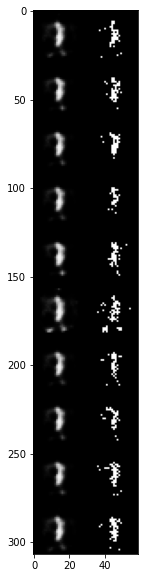

[[1.15481438e-08 4.09736600e-09 6.02096328e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.05216535e-09 5.35875211e-09 5.22059773e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.03522032e-09 9.51171852e-09 2.22330576e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.25938348e-10 4.48176884e-10 5.99168992e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.20179924e-10 7.82328702e-10 1.10413811e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00322783e-09 3.34271694e-10 4.45230630e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


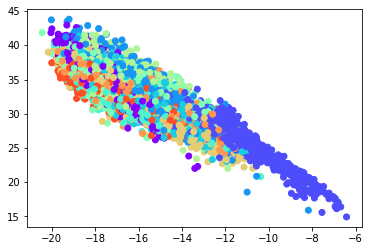

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


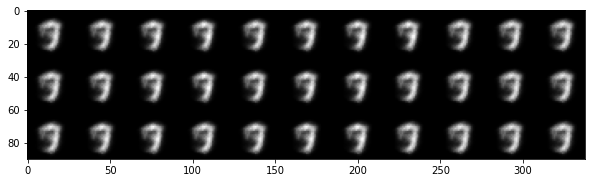

In [476]:
main()

Epoch: 0, Iter: 0, ELBO:-548.4129028320312
Epoch: 1, Iter: 100, ELBO:-362.7445373535156
Epoch: 2, Iter: 200, ELBO:-744.4341430664062
Epoch: 3, Iter: 300, ELBO:-2646.992431640625
Epoch: 4, Iter: 400, ELBO:-26929.650390625
Epoch: 5, Iter: 500, ELBO:-312524.90625
Epoch: 6, Iter: 600, ELBO:-429923.28125
Epoch: 7, Iter: 700, ELBO:-2578.660888671875
Epoch: 8, Iter: 800, ELBO:-496.16851806640625
Epoch: 9, Iter: 900, ELBO:-599.842041015625
Epoch: 10, Iter: 1000, ELBO:-319.4527282714844
Epoch: 11, Iter: 1100, ELBO:-241.54290771484375
Epoch: 12, Iter: 1200, ELBO:-417.488525390625
Epoch: 13, Iter: 1300, ELBO:-571.9960327148438
Epoch: 14, Iter: 1400, ELBO:-318.7708435058594
Epoch: 15, Iter: 1500, ELBO:-236.14236450195312
Epoch: 16, Iter: 1600, ELBO:-310.9514465332031
Epoch: 17, Iter: 1700, ELBO:-1051.553466796875
Epoch: 18, Iter: 1800, ELBO:-3760.8583984375
Epoch: 19, Iter: 1900, ELBO:-18298.86328125


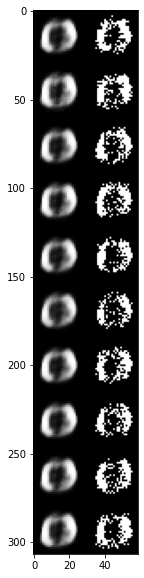

[[7.06317493e-08 2.30831780e-08 3.36616921e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.53355239e-08 3.23837419e-08 3.72890341e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.33860095e-08 5.72502010e-08 9.60308277e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.19577420e-08 7.67803812e-08 6.04772552e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.37532559e-08 1.05116214e-07 1.34621715e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.47244307e-07 3.80182570e-08 4.98819688e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


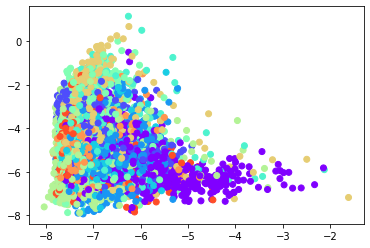

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


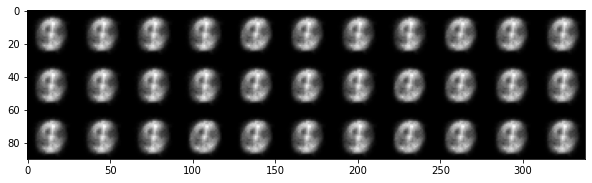

In [473]:
main()

Epoch: 0, Iter: 0, ELBO:-548.4129028320312
Epoch: 1, Iter: 100, ELBO:-362.7445373535156
Epoch: 2, Iter: 200, ELBO:-744.4341430664062
Epoch: 3, Iter: 300, ELBO:-2646.992431640625
Epoch: 4, Iter: 400, ELBO:-26929.650390625
Epoch: 5, Iter: 500, ELBO:-312524.90625
Epoch: 6, Iter: 600, ELBO:-429923.28125
Epoch: 7, Iter: 700, ELBO:-2578.660888671875
Epoch: 8, Iter: 800, ELBO:-496.16851806640625
Epoch: 9, Iter: 900, ELBO:-599.842041015625
Epoch: 10, Iter: 1000, ELBO:-319.4527282714844
Epoch: 11, Iter: 1100, ELBO:-241.54290771484375
Epoch: 12, Iter: 1200, ELBO:-417.488525390625
Epoch: 13, Iter: 1300, ELBO:-571.9960327148438
Epoch: 14, Iter: 1400, ELBO:-318.7708435058594
Epoch: 15, Iter: 1500, ELBO:-236.14236450195312
Epoch: 16, Iter: 1600, ELBO:-310.9514465332031
Epoch: 17, Iter: 1700, ELBO:-1051.553466796875
Epoch: 18, Iter: 1800, ELBO:-3760.8583984375
Epoch: 19, Iter: 1900, ELBO:-18298.86328125
Epoch: 20, Iter: 2000, ELBO:-1786.790771484375
Epoch: 21, Iter: 2100, ELBO:-1233.778076171875
Epoc

Epoch: 176, Iter: 17600, ELBO:-1176.26806640625
Epoch: 177, Iter: 17700, ELBO:-1624.91796875
Epoch: 178, Iter: 17800, ELBO:-1582.5235595703125
Epoch: 179, Iter: 17900, ELBO:-1920.9248046875
Epoch: 180, Iter: 18000, ELBO:-2452.733154296875
Epoch: 181, Iter: 18100, ELBO:-2671.305419921875
Epoch: 182, Iter: 18200, ELBO:-2717.500732421875
Epoch: 183, Iter: 18300, ELBO:-2737.739990234375
Epoch: 184, Iter: 18400, ELBO:-2943.79150390625
Epoch: 185, Iter: 18500, ELBO:-2949.222412109375
Epoch: 186, Iter: 18600, ELBO:-3057.830078125
Epoch: 187, Iter: 18700, ELBO:-3102.3642578125
Epoch: 188, Iter: 18800, ELBO:-3951.371826171875
Epoch: 189, Iter: 18900, ELBO:-4025.99755859375
Epoch: 190, Iter: 19000, ELBO:-4134.03076171875
Epoch: 191, Iter: 19100, ELBO:-4202.556640625
Epoch: 192, Iter: 19200, ELBO:-3982.938232421875
Epoch: 193, Iter: 19300, ELBO:-3829.140869140625
Epoch: 194, Iter: 19400, ELBO:-3950.024658203125
Epoch: 195, Iter: 19500, ELBO:-3989.013427734375
Epoch: 196, Iter: 19600, ELBO:-3975.1

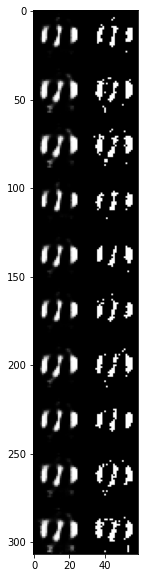

[[1.32000827e-14 4.15818765e-15 3.77596234e-15 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.41556867e-15 6.46669336e-15 6.32547688e-15 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.25469945e-15 1.35013147e-14 1.32335536e-15 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.94471693e-04 3.22748645e-04 4.86869219e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.31116854e-04 4.79906652e-04 8.28714576e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.12362167e-04 4.88336605e-04 6.34072581e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


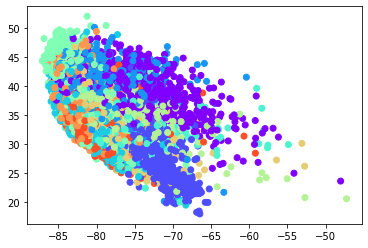

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


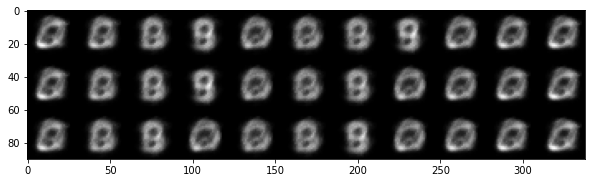

In [479]:
main()

In [141]:
hidden_units = 500
data_dimension = 784

In [195]:
x = torch.randn(5,5)


In [201]:
colors = cm.rainbow(np.linspace(0,1,10))
colors


array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.80392157e-01, 3.38158275e-01, 9.85162233e-01, 1.00000000e+00],
       [6.07843137e-02, 6.36474236e-01, 9.41089253e-01, 1.00000000e+00],
       [1.66666667e-01, 8.66025404e-01, 8.66025404e-01, 1.00000000e+00],
       [3.86274510e-01, 9.84086337e-01, 7.67362681e-01, 1.00000000e+00],
       [6.13725490e-01, 9.84086337e-01, 6.41213315e-01, 1.00000000e+00],
       [8.33333333e-01, 8.66025404e-01, 5.00000000e-01, 1.00000000e+00],
       [1.00000000e+00, 6.36474236e-01, 3.38158275e-01, 1.00000000e+00],
       [1.00000000e+00, 3.38158275e-01, 1.71625679e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]])

In [197]:
x.argmax(axis=1)

tensor([4, 1, 0, 2, 0])

In [196]:
argmax(x,axis=1)

tensor([4, 1, 0, 2, 0])

In [188]:
cm.rainbow?

In [210]:
decoder = Decoder(latent_dimension,hidden_units,data_dimension)
encoder = Encoder(latent_dimension,hidden_units,data_dimension)

In [171]:
def sample_diagonal_gaussian(mu, sigma_square):
    # Inputs:
    #   mu: mean of the gaussian [batch_size x latent_dimension]
    #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
    # Output:
    #   sample: from a diagonal gaussian with mean mu and variance sigma_square [batch_size x latent_dimension]

    # TODO: Implement the reparameterization trick and return the sample z [batch_size x latent_dimension]
    
    sample = torch.distributions.Normal(mu,torch.sqrt(sigma_square)).sample()
    #sample = m.sample()
    return sample
def sample_Bernoulli(p):
    # Input: 
    #   p: the probability of pixels labeled 1 [batch_size x data_dimension]
    # Output:
    #   x: pixels'labels [batch_size x data_dimension]

    # TODO: Implement a sampler from a Bernoulli distribution
    x = torch.bernoulli(p)
    return x

In [138]:
torch.distributions.Normal(z_mu,z_sigma).sample()

tensor([0.2096, 0.4012])

In [401]:
z_sample = 10
latent_dimension = 2
dist = []
sample = []
for i in range(z_sample):
    z_mu = torch.FloatTensor([0]*latent_dimension)
    z_sigma = torch.FloatTensor([1]*latent_dimension)
    zs = sample_diagonal_gaussian(z_mu, z_sigma**2)
    p = decoder(zs)
    dist += [array_to_image(p.detach())]
    x = sample_Bernoulli(p)
    sample += [array_to_image(x.detach())]

In [457]:
z_sample = 10
latent_dimension = 2
dist = []
sample = []
z_mu = torch.FloatTensor([[0]*latent_dimension for _ in range(z_sample)])
z_sigma = torch.FloatTensor([[1]*latent_dimension for _ in range(z_sample)])
zs = sample_diagonal_gaussian(z_mu, z_sigma)
p = decoder(zs)
image_dist = torch.tensor([array_to_image(ps.detach()) for ps in p])
x = sample_Bernoulli(p)
image_sample = torch.tensor([array_to_image(xs.detach()) for xs in x])
result = torch.cat((image_dist,image_sample))
out = concat_images(result,10,2)
print(zs.shape)

for i in range(z_sample):
    z_mu = torch.FloatTensor([0]*latent_dimension)
    
    z_sigma = torch.FloatTensor([1]*latent_dimension)
    zs = sample_diagonal_gaussian(z_mu, z_sigma**2)
    print(i,zs)
    p = decoder(zs)
    dist += [array_to_image(p.detach())]
    x = sample_Bernoulli(p)
    sample += [array_to_image(x.detach())]

torch.Size([10, 2])
0 tensor([ 0.1648, -0.7220])
1 tensor([-0.7083,  0.3610])
2 tensor([ 0.1093, -0.5427])
3 tensor([-0.9268,  0.6422])
4 tensor([0.4610, 1.0469])
5 tensor([-0.0353, -0.2500])
6 tensor([-0.5933,  0.1270])
7 tensor([-0.9273, -0.6432])
8 tensor([ 1.0945, -0.8544])
9 tensor([0.0822, 0.7079])


In [458]:
zs.shape

torch.Size([2])

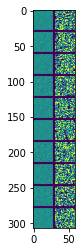

In [459]:
imshow(out)

In [460]:
dist = np.array(dist)
sample = np.array(sample)

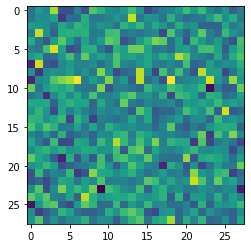

In [461]:
imshow(dist[4])

In [410]:
sample.shape

(10, 28, 28)

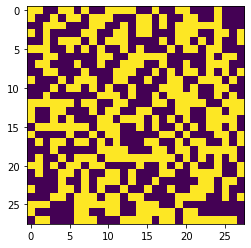

In [416]:
imshow(sample[4])

In [417]:
images = np.concatenate((dist, sample))

In [420]:
result = concat_images(images,2,10)

In [421]:
result

array([[0.42968851, 0.4789162 , 0.46469128, ..., 0.        , 1.        ,
        1.        ],
       [0.46113706, 0.46524364, 0.5024606 , ..., 0.        , 0.        ,
        0.        ],
       [0.56183726, 0.54746288, 0.44586223, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.38042939, 0.46535885, 0.5478096 , ..., 0.        , 0.        ,
        1.        ],
       [0.50827682, 0.41362461, 0.51133734, ..., 0.        , 0.        ,
        1.        ],
       [0.50270957, 0.5523414 , 0.47521353, ..., 1.        , 0.        ,
        1.        ]])

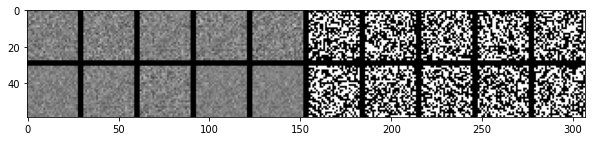

In [426]:
figure(figsize=(10,10))
imshow(result,cmap='gray')

In [189]:
N_data, strain_images, train_labels, test_images, test_labels = load_mnist()

In [298]:
colors = cm.rainbow(np.linspace(0,1,10,endpoint=False))
labels = argmax(train_labels,axis=1)

In [300]:
labels

tensor([5, 0, 4,  ..., 6, 9, 7])

In [301]:
colors[labels[0]]

array([0.50392157, 0.99998103, 0.70492555, 1.        ])

In [302]:
labels[0],labels[1],labels[2]

(tensor(5), tensor(0), tensor(4))

In [303]:
colors[4],colors[5]

(array([0.3       , 0.95105652, 0.80901699, 1.        ]),
 array([0.50392157, 0.99998103, 0.70492555, 1.        ]))

In [304]:
c[0],c[1],c[2]

(array([0.06078431, 0.63647424, 0.94108925, 1.        ]),
 array([0.61372549, 0.98408634, 0.64121331, 1.        ]),
 array([1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00]))

In [305]:
c = []
for i in range(10000):
    c += [colors[labels[i]]]
c = np.array(c)    

In [306]:
c

array([[0.50392157, 0.99998103, 0.70492555, 1.        ],
       [0.5       , 0.        , 1.        , 1.        ],
       [0.3       , 0.95105652, 0.80901699, 1.        ],
       ...,
       [0.7       , 0.95105652, 0.58778525, 1.        ],
       [1.        , 0.30315267, 0.15339165, 1.        ],
       [0.90392157, 0.80538092, 0.45124406, 1.        ]])

In [307]:
c[2],labels[2]

(array([0.3       , 0.95105652, 0.80901699, 1.        ]), tensor(4))

In [308]:
c[3],labels[3]

(array([0.30392157, 0.30315267, 0.98816547, 1.        ]), tensor(1))

In [309]:
mu,_ = encoder(train_images)

In [310]:
mu.shape

torch.Size([10000, 2])

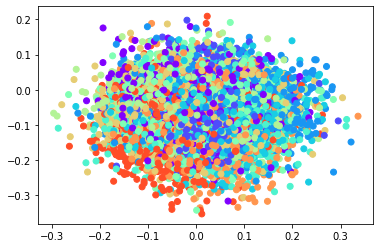

In [311]:
scatter(mu.detach()[:,0],mu.detach()[:,1],color = c)

In [256]:
colors[2]

array([0.38627451, 0.98408634, 0.76736268, 1.        ])

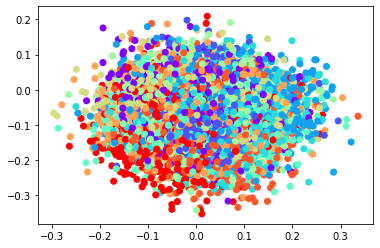

In [253]:
colors = cm.rainbow(np.linspace(0, 1, 10))
labels = train_labels.argmax(axis=1)
colors = [colors[i] for i in labels]
# for i, m in enumerate(mu):
#     label = self.train_labels[i].argmax()
# TODO: Plot these mean vectors in the latent space with a scatter
# Colour each point depending on the class label 
    # plt.scatter(*np.array(m.detach()), label=label, color=colors[label])
plt.scatter(mu[:,0].detach(), mu[:,1].detach(), color=colors)

In [207]:
c

array([1.        , 0.63647424, 0.33815827, 1.        ])

In [191]:
train_labels.shape

torch.Size([10000, 10])

In [194]:
train_labels[0]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [150]:
z_mu = torch.FloatTensor([[0]*latent_dimension for _ in range(10)])

In [154]:
z_sigma = torch.FloatTensor([[1]*latent_dimension for _ in range(10)])

In [159]:
zs = sample_diagonal_gaussian(z_mu, z_sigma)
zs

tensor([[ 0.0071, -0.8040],
        [-0.0973,  0.1380],
        [-1.0513, -0.4584],
        [ 0.1060,  1.9048],
        [ 0.8199,  0.7436],
        [ 1.7554,  0.3149],
        [ 1.3926, -0.5591],
        [-0.2311,  0.1574],
        [ 1.1852,  0.5135],
        [-1.8551,  0.0408]])

In [161]:
ps = decoder(zs)
images_p = torch.tensor([array_to_image(p.detach()) for p in ps])

In [162]:
images_p.shape

torch.Size([10, 28, 28])

In [320]:
labels = train_labels.argmax(axis=1)
train_images[labels==2][:2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [323]:
(labels==2).shape

torch.Size([10000])

In [321]:
train_images

torch.Size([10000, 784])

In [326]:
x1 = train_images[labels==1]#[:2]


In [327]:
x1.shape

torch.Size([1127, 784])

In [ ]:
x1 = self.train_images[labels==1][:2]
        x2 = self.train_images[labels==2][:2]
        x3 = self.train_images[labels==3][:2]

        # TODO: Encode the data in each pair, and take the mean vectors
        mu1, sigma_square1 = self.encoder(x1)
        mu2, sigma_square2 = self.encoder(x2)
        mu3, sigma_square3 = self.encoder(x3)

        # TODO: Linearly interpolate between these mean vectors (Use the function interpolate_mu)
        z_a1 = self.interpolate_mu(mu1[0], mu1[1], 0.1)
        z_a2 = self.interpolate_mu(mu2[0], mu2[1], 0.1)
        z_a3 = self.interpolate_mu(mu3[0], mu3[1], 0.1)

In [328]:
def interpolate_mu(mua, mub, alpha = 0.5):
    return alpha*mua + (1-alpha)*mub

In [329]:
mu,_ = encoder(train_images[labels==1][:2])

In [336]:
mu,_ = encoder(train_images[0])
mu2,_=encoder(train_images[1])

In [334]:
mu

tensor([-0.0423,  0.0003], grad_fn=<AddBackward0>)

In [337]:
interpolate_mu(mu,mu2)

tensor([-0.0407,  0.0050], grad_fn=<AddBackward0>)

In [339]:
decoder(interpolate_mu(mu,mu2)).shape

torch.Size([784])

In [340]:
labels[0],labels[1],labels[2]

(tensor(5), tensor(0), tensor(4))

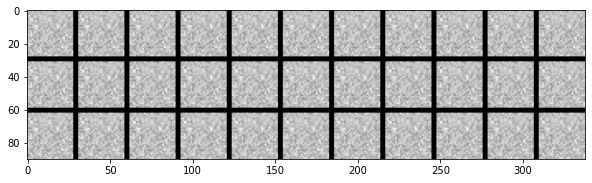

In [381]:
p1 = train_images[0]
p2 = train_images[1]
p3 = train_images[2]

mu1,_ = encoder(p1)
mu2,_ = encoder(p2)
mu3,_ = encoder(p3)

a = np.linspace(0,1,11)


image12 = []
image13 = []
image23 = []
for step in a:
    z_12 = interpolate_mu(mu1,mu2)
    z_13 = interpolate_mu(mu1,mu3)
    z_23 = interpolate_mu(mu2,mu3)
    p12 = decoder(z_12)
    p13 = decoder(z_13)
    p23 = decoder(z_23)
    image12 += [array_to_image(p12.detach())]
    image13 += [array_to_image(p13.detach())]
    image23 += [array_to_image(p23.detach())]

image12 = array(image12)
image13 = array(image13)
image23 = array(image23)

image = np.concatenate((image12,image13))
image = np.concatenate((image,image23))
out = concat_images(image,3,11)
figure(figsize=(10,10))
plt.imshow(out, 'gray')
plt.savefig('test.png')
plt.show()